<a href="https://colab.research.google.com/github/Marcollins2/MachineLearning/blob/main/Microexpression_Detection_Grp_7E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing all the necessary libraries


In [5]:
import tensorflow as tf
import keras
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
#import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense, Resizing
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature



In [6]:
#Connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Configuration and Directory Setup for Micro Expressions Recognition


In [7]:
train_directory = "/content/gdrive/MyDrive/Micro_Expressions/train"
validation_directory = "/content/gdrive/MyDrive/Micro_Expressions/test"
CLASS_NAMES = ["anger", "disgust","fear",  "happiness", "neutral","sadness", "surprise"]

CONFIGURATION = {
    "BATCH_SIZE" : 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 7,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

Creating Categorical Image Dataset for Training

In [8]:
#
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 7620 files belonging to 7 classes.


Creating Categorical Image Dataset for Micro Expressions Validation

In [9]:
#
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode='categorical',
    class_names= CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)


Found 1860 files belonging to 7 classes.


In [10]:
for i in validation_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 50.      ,  36.      ,  51.      ],
         [ 50.      ,  36.      ,  51.      ],
         [ 48.59375 ,  34.59375 ,  49.59375 ],
         ...,
         [ 55.09375 ,  38.09375 ,  56.09375 ],
         [ 52.      ,  35.      ,  53.      ],
         [ 52.      ,  35.      ,  53.      ]],

        [[ 50.      ,  36.      ,  51.      ],
         [ 50.      ,  36.      ,  51.      ],
         [ 48.59375 ,  34.59375 ,  49.59375 ],
         ...,
         [ 55.09375 ,  38.09375 ,  56.09375 ],
         [ 52.      ,  35.      ,  53.      ],
         [ 52.      ,  35.      ,  53.      ]],

        [[ 48.875   ,  34.875   ,  49.875   ],
         [ 48.875   ,  34.875   ,  49.875   ],
         [ 48.180664,  34.180664,  49.338867],
         ...,
         [ 56.666992,  39.666992,  57.666992],
         [ 53.96875 ,  36.96875 ,  54.96875 ],
         [ 53.96875 ,  36.96875 ,  54.96875 ]],

        ...,

        [[204.71875 , 166.4375  

Visualizing Sample Images from the Micro Expressions Training Dataset

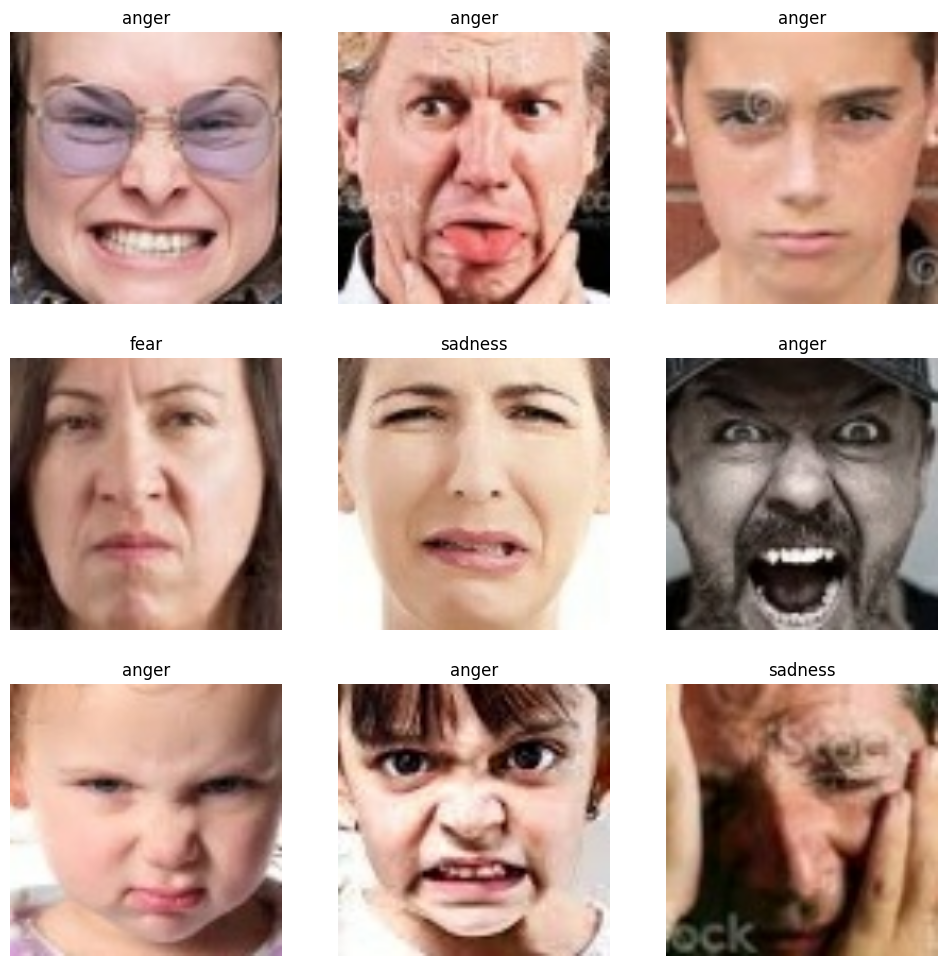

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0). numpy()])
    plt.axis("off")



Prefetching Micro Expressions Training Dataset for Improved Performance

In [12]:
training_dataset ={
    train_dataset
    .prefetch(tf.data.AUTOTUNE)

}


Prefetching Micro Expressions Validation Dataset for Improved Performance

In [13]:
validation_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)



Image Preprocessing Layers: Resizing and Rescaling

In [14]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE']),
    Rescaling (1./255),

])

### LeNet Model for Micro Expressions Recognition

In [15]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (CONFIGURATION['IM_SIZE'], CONFIGURATION['IM_SIZE'], 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

### ResNet 34 architecture

In [16]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [17]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)


In [18]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [19]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,256,256,3]), training = False)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_2 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

In [21]:
loss_function = CategoricalCrossentropy()

In [23]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [24]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics)


In [ ]:
history = resnet_34.fit(
  train_dataset,
  validation_data = validation_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,


)

### Training

In [26]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics)


In [27]:
history = lenet_model.fit(
  train_dataset,
  validation_data = validation_dataset,
epochs = CONFIGURATION['N_EPOCHS'],
verbose = 1,

)

Epoch 1/20
239/239 [==============================] - 1688s 7s/step - loss: 1.4761 - accuracy: 0.4143 - top_k_accuracy: 0.5994 - val_loss: 2.3416 - val_accuracy: 0.2824 - val_top_k_accuracy: 0.4249
Epoch 2/20
239/239 [==============================] - 762s 3s/step - loss: 0.8606 - accuracy: 0.7014 - top_k_accuracy: 0.8563 - val_loss: 2.1426 - val_accuracy: 0.3429 - val_top_k_accuracy: 0.5062
Epoch 3/20
239/239 [==============================] - 762s 3s/step - loss: 0.4939 - accuracy: 0.8412 - top_k_accuracy: 0.9421 - val_loss: 0.2732 - val_accuracy: 0.9269 - val_top_k_accuracy: 0.9776
Epoch 4/20
239/239 [==============================] - 761s 3s/step - loss: 0.2307 - accuracy: 0.9307 - top_k_accuracy: 0.9841 - val_loss: 0.5255 - val_accuracy: 0.8293 - val_top_k_accuracy: 0.9361
Epoch 5/20
239/239 [==============================] - 821s 3s/step - loss: 0.1369 - accuracy: 0.9609 - top_k_accuracy: 0.9928 - val_loss: 0.2030 - val_accuracy: 0.9370 - val_top_k_accuracy: 0.9815
Epoch 6/20
239

Training and Validation Loss Plot

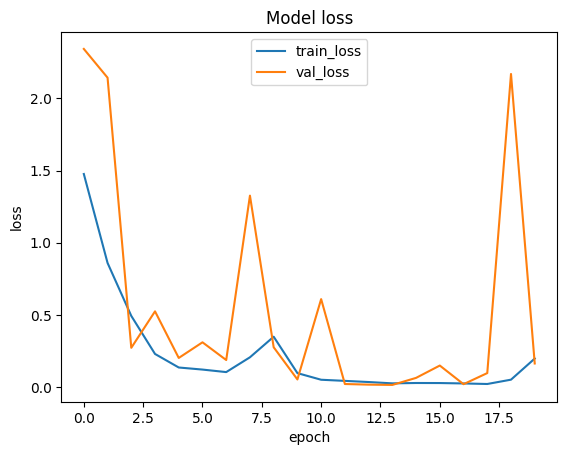

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

Training and Validation Accuracy Plot

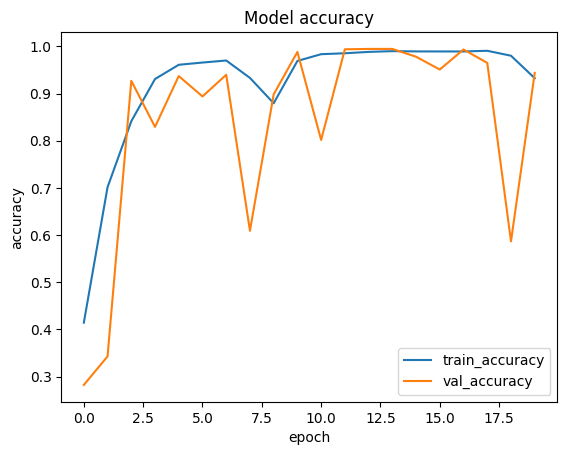

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### EVALUATION

In [30]:
lenet_model.evaluate(validation_dataset)

239/239 [==============================] - 149s 618ms/step - loss: 0.1645 - accuracy: 0.9437 - top_k_accuracy: 0.9886


[0.16454164683818817, 0.9437007904052734, 0.9885826706886292]

Testing the Micro Expressions Recognition Model on a Single Image

In [31]:
test_image = cv2.imread("/content/gdrive/MyDrive/schola.jpg")
test_image = cv2.resize(test_image, (CONFIGURATION["IM_SIZE"] ,CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)
print(lenet_model(im))

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])


tf.Tensor(
[[2.06794994e-05 5.93665929e-04 9.26550420e-05 9.05411661e-01
  4.77866794e-04 1.20041026e-04 9.32835788e-02]], shape=(1, 7), dtype=float32)
happiness


Visualizing Predictions on Validation Dataset

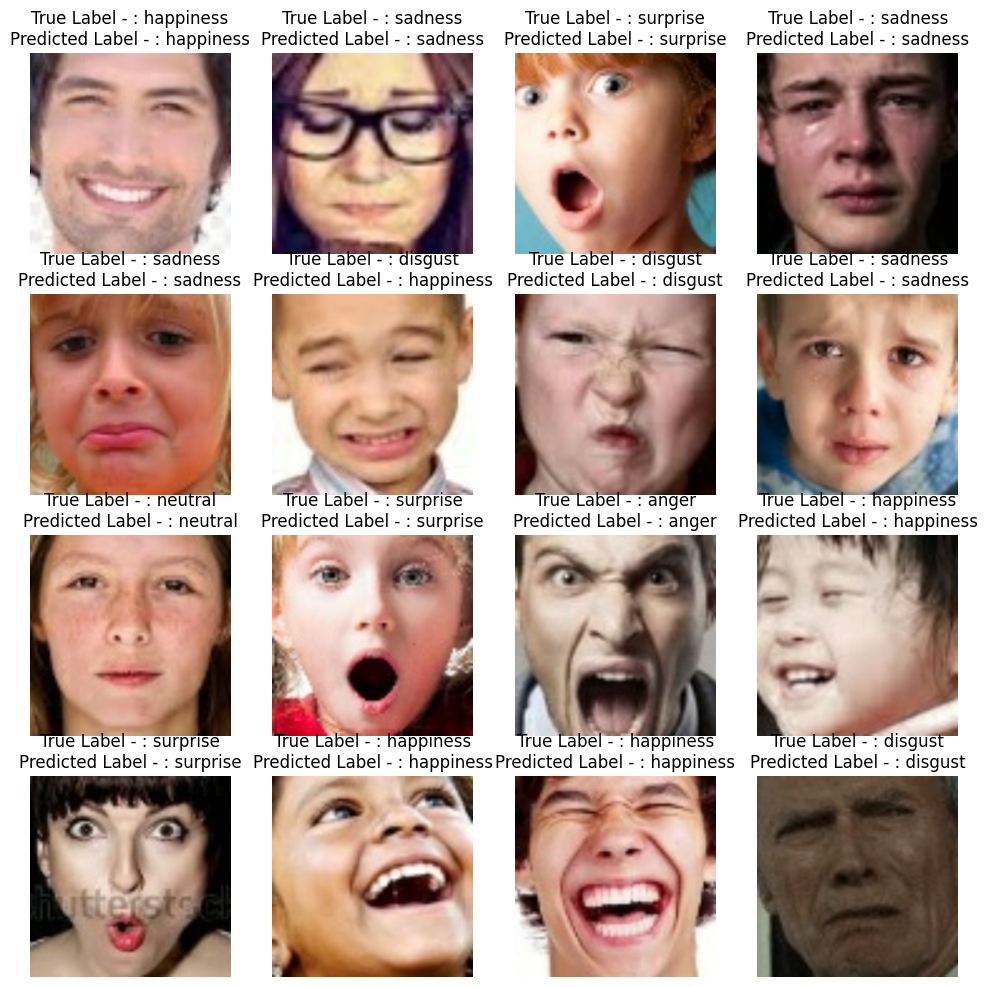

In [32]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CLASS_NAMES[int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

# Generating Predictions for the Entire Validation Dataset

In [33]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [34]:
print(labels)

[array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1.],


Consolidating Predictions and True Labels for Evaluation

In [35]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

# Confusion Matrix Visualization

[[1380    6    6    7    5    3   14]
 [  37  595    4   15    5    2    4]
 [   7    2  453   12    1    0   14]
 [  24    6    2 1903    1    3   11]
 [  16    1    0   14  604    6    3]
 [  60   24    4   49   21 1196   15]
 [   9    1    5    5    2    3 1060]]


Text(0.5, 58.7222222222222, 'Predicted')

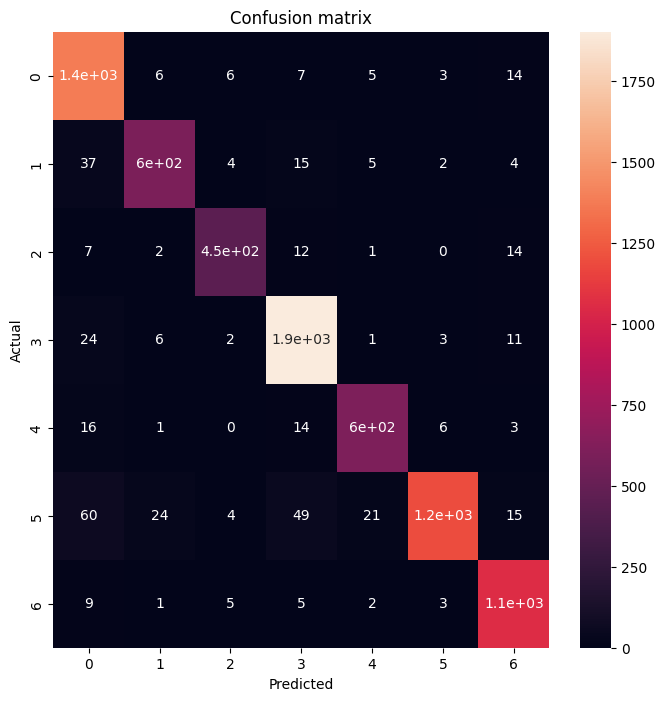

In [36]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')